In [1]:
import pandas as pd

sample_data = pd.read_csv('data/by_stock_merged/600169.csv')
print(sample_data.head())

            trade_time  open  high   low  close     vol   amount
0  2000-01-04 09:31:00  6.50  6.50  6.50   6.50     0.0      0.0
1  2000-01-04 09:32:00  6.50  6.50  6.50   6.50  3300.0  21450.0
2  2000-01-04 09:33:00  6.55  6.55  6.55   6.55  1300.0   8515.0
3  2000-01-04 09:34:00  6.55  6.55  6.55   6.55     0.0      0.0
4  2000-01-04 09:35:00  6.54  6.54  6.54   6.54  1000.0   6540.0


### 获得所有股票的所有停牌日期

In [1]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# 定义处理单个文件的函数
def process_file(file_path):
    try:
        df = pd.read_csv(file_path)
        # 将trade_time列转换为日期格式，并提取日期
        df['date'] = pd.to_datetime(df['trade_time']).dt.date
        # 按日期汇总交易额
        daily_amount_sum = df.groupby('date')['amount'].sum()
        # 找到总交易额为0的日期
        suspend_days = daily_amount_sum[daily_amount_sum == 0].index.tolist()
        return os.path.basename(file_path).split('.')[0], suspend_days
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return os.path.basename(file_path).split('.')[0], []

files_dir = 'data/by_stock_merged/'
files = [os.path.join(files_dir, file) for file in os.listdir(files_dir)]

num_workers = max(1, os.cpu_count() - 1)
results = []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(process_file, file) for file in files]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results.append(future.result())


results_df = pd.DataFrame(results, columns=['ticker', 'suspend_days'])
results_df.set_index('ticker', inplace=True)
output_path = 'data/all_suspend_days.pkl.zip'
results_df.to_pickle(output_path, compression='zip')

print(f"Results saved to {output_path}")


Processing Files: 100%|██████████| 5100/5100 [50:32<00:00,  1.68it/s]  


Results saved to data/all_suspend_days.pkl.zip


In [2]:
# results_df data check
print(results_df.head())
# print the top 20 tickers with most suspend days and the suspend days count. 
print(results_df.explode('suspend_days').value_counts('ticker').head(20))

       suspend_days
ticker             
301390           []
301130           []
301509           []
688137           []
688203           []
ticker
000670    2306
000557    1377
600556    1377
000688    1328
000403    1307
000757    1294
600817    1212
000622    1173
000672    1165
600898    1138
000498    1133
000681    1126
000156    1110
000029    1033
000863    1021
600705    1015
600633     987
000981     972
600681     953
000820     937
Name: count, dtype: int64


In [9]:
daily_data_dir = 'data/daily_raw_data/'
daily_files = os.listdir(daily_data_dir)

def validate_ticker(ticker, suspend_days):
    # 寻找匹配的日线数据文件
    daily_file = None
    for file in daily_files:
        if file.startswith(ticker + "."):
            daily_file = file
            break
    
    # 检查是否找到日线数据文件
    if daily_file is None:
        return None  # 未找到对应日线数据文件
    
    # 读取日线数据文件
    daily_df = pd.read_csv(os.path.join(daily_data_dir, daily_file), encoding='GBK')
    # 转换交易时间为日期格式
    daily_df['交易时间'] = pd.to_datetime(daily_df['交易时间'], format='%Y%m%d').dt.date
    
    # 检查是否有误判的停牌日期
    misjudged_dates = [suspend_date for suspend_date in suspend_days if suspend_date in daily_df['交易时间'].values]
    
    return misjudged_dates

# 并行处理
num_workers = max(1, os.cpu_count() - 1)
issues = {}

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = {}
    for index, row in results_df.iterrows():
        futures[executor.submit(validate_ticker, row['ticker'], row['suspend_days'])] = row['ticker']
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Validating Tickers"):
        ticker = futures[future]
        result = future.result()
        if result:
            issues[ticker] = result

# 检查issues是否为空，如果不为空则打印有问题的ticker和日期
if issues:
    for ticker, dates in issues.items():
        print(f"{ticker}: {dates}")
else:
    print("No issues found.")


Validating Tickers: 100%|██████████| 5100/5100 [00:22<00:00, 226.30it/s]  

000547: [datetime.date(2003, 1, 17)]
000868: [datetime.date(2003, 1, 17)]
000546: [datetime.date(2001, 5, 11), datetime.date(2001, 6, 1), datetime.date(2001, 10, 12), datetime.date(2002, 1, 18)]
600661: [datetime.date(2003, 1, 22)]
600505: [datetime.date(2017, 8, 21)]
600526: [datetime.date(2017, 8, 21)]
000622: [datetime.date(2001, 8, 16), datetime.date(2001, 8, 31)]
000520: [datetime.date(2003, 1, 17)]
600818: [datetime.date(2001, 1, 2), datetime.date(2001, 12, 7)]
000789: [datetime.date(2003, 1, 22)]
600863: [datetime.date(2017, 8, 21)]
000657: [datetime.date(2001, 8, 16), datetime.date(2001, 8, 31), datetime.date(2024, 1, 8)]
000906: [datetime.date(2002, 2, 25), datetime.date(2002, 2, 27)]
600604: [datetime.date(2003, 1, 15)]
600754: [datetime.date(2001, 5, 22)]
600892: [datetime.date(2003, 1, 21)]
000042: [datetime.date(2003, 1, 9), datetime.date(2003, 1, 22)]
600186: [datetime.date(2003, 1, 13)]
000430: [datetime.date(2003, 1, 9)]
600519: [datetime.date(2003, 1, 22)]
000816: [dat

In [10]:
# print top 20 tickers with most misjudged suspend days and the misjudged suspend days count.
print(pd.Series({ticker: len(dates) for ticker, dates in issues.items()}).sort_values(ascending=False).head(20))


600671    127
600898     29
600422     15
600633      9
600837      9
600721      5
600833      4
000546      4
000820      4
000012      3
000595      3
600855      3
000411      3
000657      3
000498      3
600083      2
000831      2
600261      2
000536      2
000153      2
dtype: int64


In [13]:
# print 600671 ticker's misjudged suspend days and original suspend days
ticker = '600671'
print(results_df[results_df['ticker'] == ticker]['suspend_days'].values[0])
print(issues[ticker])


[datetime.date(2000, 5, 26), datetime.date(2001, 5, 18), datetime.date(2002, 5, 28), datetime.date(2003, 5, 28), datetime.date(2003, 7, 1), datetime.date(2003, 7, 2), datetime.date(2003, 7, 3), datetime.date(2003, 7, 4), datetime.date(2003, 7, 7), datetime.date(2003, 7, 8), datetime.date(2003, 7, 9), datetime.date(2003, 7, 10), datetime.date(2003, 7, 11), datetime.date(2003, 7, 14), datetime.date(2003, 7, 15), datetime.date(2003, 7, 16), datetime.date(2003, 7, 17), datetime.date(2003, 7, 18), datetime.date(2003, 7, 21), datetime.date(2003, 7, 22), datetime.date(2003, 7, 23), datetime.date(2003, 7, 24), datetime.date(2003, 7, 25), datetime.date(2003, 7, 28), datetime.date(2003, 7, 29), datetime.date(2003, 7, 30), datetime.date(2003, 7, 31), datetime.date(2003, 8, 1), datetime.date(2003, 8, 4), datetime.date(2003, 8, 5), datetime.date(2003, 8, 6), datetime.date(2003, 8, 7), datetime.date(2003, 8, 8), datetime.date(2003, 8, 11), datetime.date(2003, 8, 12), datetime.date(2003, 8, 13), date

In [14]:
ticker = '600898'
print(results_df[results_df['ticker'] == ticker]['suspend_days'].values[0])
print(issues[ticker])

[datetime.date(2000, 6, 16), datetime.date(2000, 6, 19), datetime.date(2000, 6, 20), datetime.date(2000, 6, 21), datetime.date(2000, 6, 22), datetime.date(2000, 6, 29), datetime.date(2000, 8, 22), datetime.date(2000, 8, 23), datetime.date(2000, 8, 24), datetime.date(2000, 8, 25), datetime.date(2000, 8, 28), datetime.date(2000, 8, 29), datetime.date(2000, 8, 30), datetime.date(2000, 8, 31), datetime.date(2000, 9, 1), datetime.date(2000, 9, 4), datetime.date(2000, 9, 5), datetime.date(2000, 9, 6), datetime.date(2000, 9, 7), datetime.date(2000, 9, 8), datetime.date(2000, 9, 11), datetime.date(2000, 9, 12), datetime.date(2000, 9, 13), datetime.date(2000, 9, 14), datetime.date(2000, 9, 15), datetime.date(2000, 9, 18), datetime.date(2000, 9, 19), datetime.date(2000, 9, 20), datetime.date(2000, 9, 21), datetime.date(2000, 9, 22), datetime.date(2000, 9, 25), datetime.date(2000, 9, 26), datetime.date(2000, 9, 27), datetime.date(2000, 9, 28), datetime.date(2000, 9, 29), datetime.date(2000, 10, 9

In [18]:
print(results_df.head(20))

    ticker                                       suspend_days
0   688523                                                 []
1   301390                                                 []
2   688203                                                 []
3   301509                                                 []
4   301130                                                 []
5   688137                                                 []
6   688330                                                 []
7   688683                                                 []
8   688281                                                 []
9   688319                                                 []
10  688536  [2023-05-29, 2023-05-30, 2023-05-31, 2023-06-0...
11  605008                                                 []
12  301181                                                 []
13  301037                                                 []
14  688577                                                 []
15  6010

### 使用停牌日期数据处理收益率数据

读取股票收益率

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

stock_data_df = pd.read_pickle('data/stock_returns_1m_all.pkl.gz', compression='gzip')
print(stock_data_df.head())

# # 创建一个新的DataFrame，以避免修改原始的DataFrame
# modified_stock_data_df = stock_data_df.copy()

                     301515  601238  605222  002011  688048  002483  002949  \
trade_time                                                                    
2000-01-04 09:31:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:32:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:33:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:34:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2000-01-04 09:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     300439    000042  603200  ...  600400  001965  300203  \
trade_time                                     ...                           
2000-01-04 09:31:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:32:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:33:00     NaN  0.000000     NaN  ...     NaN     NaN     NaN   
2000-01-04 09:34:00     NaN  0.000000     NaN  ...     N

读取停牌日期

In [3]:
results_df = pd.read_pickle('data/all_suspend_days.pkl.zip', compression='zip')
print(results_df.head(20))

                                             suspend_days
ticker                                                   
301390                                                 []
301130                                                 []
301509                                                 []
688137                                                 []
688203                                                 []
688523                                                 []
688330                                                 []
688683                                                 []
688281                                                 []
301181                                                 []
301037                                                 []
605008                                                 []
688536  [2023-05-29, 2023-05-30, 2023-05-31, 2023-06-0...
688577                                                 []
688319                                                 []
300777        

In [8]:
# 打印modified_stock_data_df索引的类型和前几个时间戳
print(type(stock_data_df.index))
print(stock_data_df.index[:5])

# 选择一个示例股票，并打印其停牌日期类型和值
example_ticker = results_df.index[100]  # 取第一个股票代码作为示例
example_dates = results_df.at[example_ticker, 'suspend_days']
print(type(example_dates[0]) if example_dates else "No suspend dates")
print(example_dates[:5] if example_dates else "No suspend dates")

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2000-01-04 09:31:00', '2000-01-04 09:32:00',
               '2000-01-04 09:33:00', '2000-01-04 09:34:00',
               '2000-01-04 09:35:00'],
              dtype='datetime64[ns]', name='trade_time', freq=None)
No suspend dates
No suspend dates


停牌数据处理

In [5]:
stock_data_df.index = pd.to_datetime(stock_data_df.index)

# 遍历所有股票和对应的停牌日期
for ticker, suspend_dates in tqdm(results_df['suspend_days'].items(), total=results_df.shape[0], desc="Updating stock data"):
    ticker = str(ticker)  # 确保ticker格式为字符串，以匹配列名
    if suspend_dates:  # 如果有停牌日期
        for suspend_date in suspend_dates:  # 这里suspend_date是datetime.date类型
            # 创建当天的时间范围
            start_datetime = pd.Timestamp(suspend_date)
            end_datetime = start_datetime + pd.Timedelta(days=1)
            # 设置对应日期的收益率为NaN
            if ticker in stock_data_df.columns:
                # 查找这个日期范围内的所有时间点，并将它们设置为NaN
                stock_data_df.loc[(stock_data_df.index >= start_datetime) & (stock_data_df.index < end_datetime), ticker] = np.nan

#47mins on 60 c2

Updating stock data:   1%|          | 31/5100 [00:00<00:16, 306.57it/s]

Updating stock data: 100%|██████████| 5100/5100 [46:45<00:00,  1.82it/s]  


多进程计算（弃用）

In [ ]:
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

# 假设 results_df 和 modified_stock_data_df 已经被定义和初始化

# 这个函数处理单个股票和其所有停牌日期
def update_stock_data(args):
    ticker, suspend_dates, stock_data_df = args
    for suspend_date in suspend_dates:
        # 创建当天的时间范围
        start_datetime = pd.Timestamp(suspend_date)
        end_datetime = start_datetime + pd.Timedelta(days=1)
        if ticker in stock_data_df.columns:
            # 查找这个日期范围内的所有时间点，并将它们设置为NaN
            stock_data_df.loc[(stock_data_df.index >= start_datetime) & (stock_data_df.index < end_datetime), ticker] = np.nan
    return stock_data_df

# 准备传递给进程的参数
args_list = [(ticker, suspend_dates, stock_data_df.copy()) for ticker, suspend_dates in results_df['suspend_days'].items()]

# 使用所有可用的CPU核心，但留一个核心不用
cpu_count = max(1, multiprocessing.cpu_count() - 1)

# 更新数据
with ProcessPoolExecutor(max_workers=cpu_count) as executor:
    results = list(tqdm(executor.map(update_stock_data, args_list), total=len(args_list)))

# 合并结果
for updated_df in results:
    stock_data_df.update(updated_df)


以000603 20090115的数据进行初步检验 

In [6]:
# 试图获取某一特定日期的数据
sample_date = pd.Timestamp('2009-01-15')
sample_ticker = '000603'  # 以具体股票代码为例
try:
    # 使用正规化日期来确保比较的是日期而非时间戳
    selected_data = stock_data_df.loc[stock_data_df.index.normalize() == sample_date, sample_ticker]
    print(selected_data.head(20))
except KeyError as e:
    print(f"Error: {e}. The ticker or date may not exist in the DataFrame.")
except Exception as e:
    print(f"Unexpected error: {e}")

trade_time
2009-01-15 09:31:00   NaN
2009-01-15 09:32:00   NaN
2009-01-15 09:33:00   NaN
2009-01-15 09:34:00   NaN
2009-01-15 09:35:00   NaN
2009-01-15 09:36:00   NaN
2009-01-15 09:37:00   NaN
2009-01-15 09:38:00   NaN
2009-01-15 09:39:00   NaN
2009-01-15 09:40:00   NaN
2009-01-15 09:41:00   NaN
2009-01-15 09:42:00   NaN
2009-01-15 09:43:00   NaN
2009-01-15 09:44:00   NaN
2009-01-15 09:45:00   NaN
2009-01-15 09:46:00   NaN
2009-01-15 09:47:00   NaN
2009-01-15 09:48:00   NaN
2009-01-15 09:49:00   NaN
2009-01-15 09:50:00   NaN
Name: 000603, dtype: float64


<Axes: title={'center': '000603 Cumulative Return'}, xlabel='trade_time'>

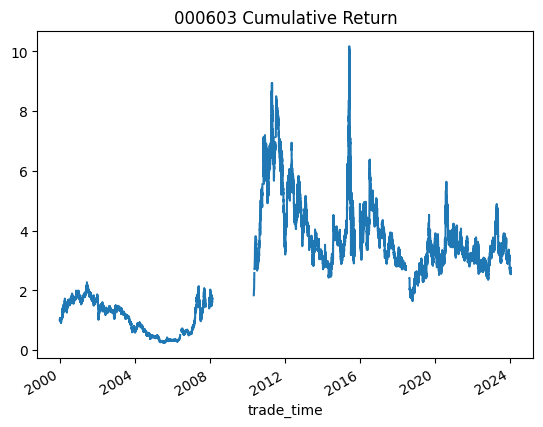

In [7]:
from matplotlib import pyplot as plt
ticker = '000603'
#plot the cumprod of stock return of 000603
stock_data_df[ticker].add(1).cumprod().plot(title=f"{ticker} Cumulative Return")

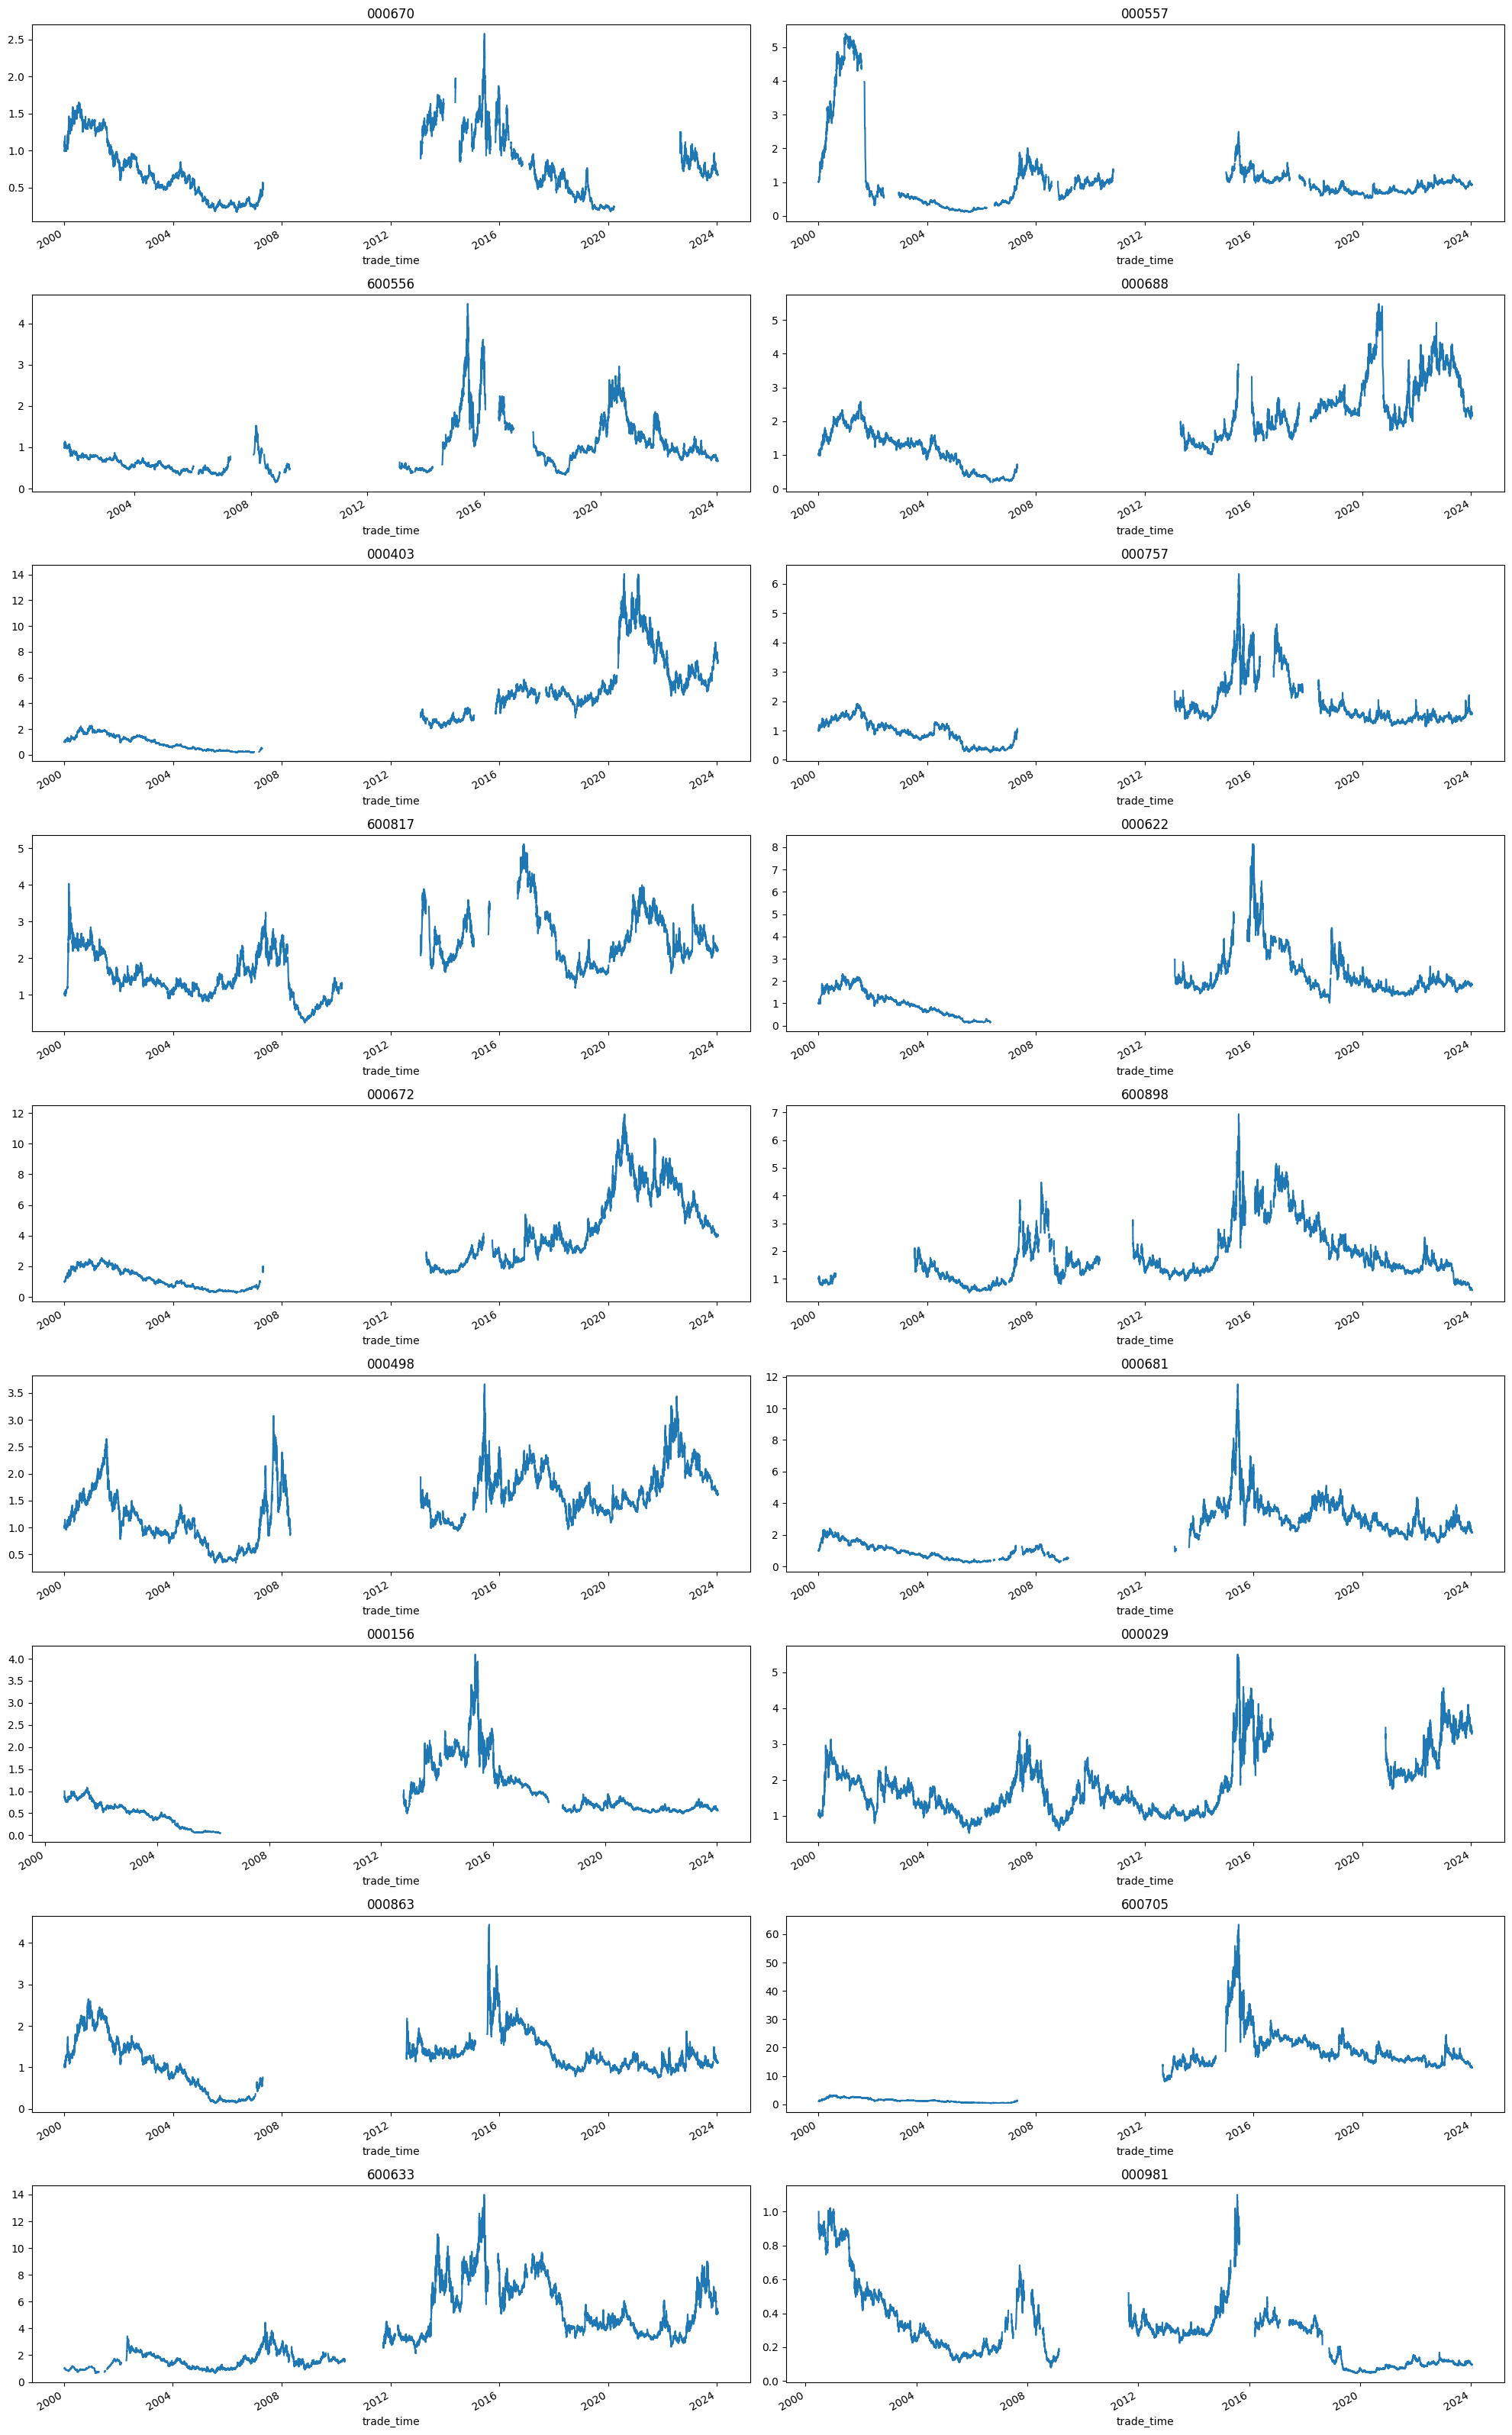

In [12]:
import matplotlib.pyplot as plt

# Defined stock tickers array
tickers = [
    "000670", "000557", "600556", "000688", "000403",
    "000757", "600817", "000622", "000672", "600898",
    "000498", "000681", "000156", "000029", "000863",
    "600705", "600633", "000981"
]

# Create subplots with 2 columns and 5 rows, make it wider
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(20, 32))  # Adjust for size

# Loop through all stock tickers and corresponding subplot axes
for i, ticker in enumerate(tickers):
    ax = axes[i // 2, i % 2]  # Locate current subplot
    stock_data_df[ticker].add(1).cumprod().plot(ax=ax, title=f"{ticker}")  # Plot on current subplot
    # ax.legend([ticker])  # Add legend

# Adjust subplot spacing
plt.tight_layout()
plt.show()



In [13]:
stock_data_df.to_pickle('data/stock_returns_1m_all_rm_suspension.pkl.gz', compression='gzip')
# 77m?